<a href="https://colab.research.google.com/github/Louis5228/DLP-lab/blob/main/EEG_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%cd DLP-lab/Lab3/

/home/louis/DLP-lab/Lab3


In [3]:
!pwd

/home/louis/DLP-lab/Lab3


In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from dataloader import read_bci_data

In [5]:
train_x, train_t, test_x, test_t = read_bci_data()

dataset_train = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_t))
loader_train = DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=4)

dataset_test = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_t))
loader_test = DataLoader(dataset_test, batch_size=256, shuffle=False, num_workers=4)

print("test dataset:\n", dataset_test[:5])

(1080, 1, 2, 750) (1080,) (1080, 1, 2, 750) (1080,)
test dataset:
 (tensor([[[[ -8.3359,  -8.7829,  -9.3748,  ...,  -2.1328,  -2.8224,  -2.0885],
          [-10.6524,  -8.4476,  -5.9331,  ...,   0.5607,  -4.1266,  -8.1379]]],


        [[[ -1.6904,  -3.2816,  -3.6523,  ...,   4.0093,   0.7018,   0.7155],
          [  3.4033,   2.0698,  -1.6959,  ...,   7.7458,   3.5498,   3.7207]]],


        [[[ -2.6835,  -0.4836,   1.9848,  ...,  -3.9513,   0.4729,   5.2923],
          [  2.6602,   3.9587,   4.9871,  ...,  -0.6675,  -0.2266,   0.0633]]],


        [[[  2.3342,   0.6194,  -1.9070,  ...,  -2.2655,  -5.7164,  -8.4991],
          [  1.2229,   1.9431,   1.2519,  ...,  -6.1559,  -6.6869,  -7.4559]]],


        [[[  0.7491,   0.4653,  -0.4241,  ...,  -2.0870,  -5.9208,  -5.2572],
          [  3.8061,   2.8479,   1.0993,  ...,  -1.1100,  -2.9349,  -3.1683]]]],
       dtype=torch.float64), tensor([1., 0., 1., 1., 1.], dtype=torch.float64))


sample_id : 699


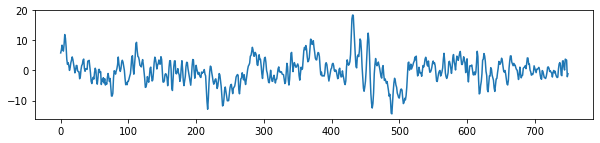

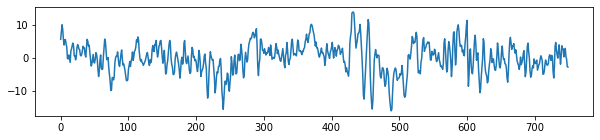

In [6]:
rand = int(np.random.randint(0, train_x.shape[0], 1))
print("sample_id :", rand)
plt.figure(figsize=(10, 2))
plt.plot(train_x[rand, 0, 0])
plt.figure(figsize=(10, 2))
plt.plot(train_x[rand, 0, 1])
plt.show()

In [7]:
class EEGNet(nn.Module):
  def __init__(self, activation=nn.ReLU()):
    super(EEGNet, self).__init__()
    self.firstconv = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=(1, 51), stride=(1, 1), padding=(0, 25), bias=False),
        nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    self.depthwiseConv = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=(2, 1), stride=(1,1), groups=16, bias=False),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        activation,
        nn.AvgPool2d(kernel_size=(1,4),stride=(1,4),padding=0),
        nn.Dropout(p=0.25)
    )
    self.seperableConv = nn.Sequential(
        nn.Conv2d(32, 32, kernel_size=(1, 15), stride=(1, 1), padding=(0, 7), bias=False),
        nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        activation,
        nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
        nn.Dropout(p=0.25)
    )
    self.classify = nn.Linear(736, 2, bias=True)

  def forward(self, x):
    out = self.firstconv(x)
    out = self.depthwiseConv(out)
    out = self.seperableConv(out)
    out = out.view(out.shape[0], -1)
    out = self.classify(out)
    return out

In [57]:
class DeepConvNet(nn.Module):
  def __init__(self, activation=nn.ReLU()):
    super(DeepConvNet,self).__init__()
    self.conv0 = nn.Conv2d(1, 25, kernel_size=(1,5))
    self.conv1 = nn.Sequential(
        nn.Conv2d(25, 25, kernel_size=(2, 1)),
        nn.BatchNorm2d(25, eps=1e-05, momentum=0.1),
        activation,
        nn.MaxPool2d(kernel_size=(1, 2)),
        nn.Dropout(p=0.5)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(25, 50, kernel_size=(1, 5)),
        nn.BatchNorm2d(50, eps=1e-05, momentum=0.1),
        activation,
        nn.MaxPool2d(kernel_size=(1, 2)),
        nn.Dropout(p=0.5)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(50, 100, kernel_size=(1, 5)),
        nn.BatchNorm2d(100, eps=1e-05, momentum=0.1),
        activation,
        nn.MaxPool2d(kernel_size=(1, 2)),
        nn.Dropout(p=0.5)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(100, 200, kernel_size=(1, 5)),
        nn.BatchNorm2d(200, eps=1e-05, momentum=0.1),
        activation,
        nn.MaxPool2d(kernel_size=(1, 2)),
        nn.Dropout(p=0.5)
    )
    self.classify = nn.Linear(8600, 2)
      
  def forward(self, x):
    out = self.conv0(x)
    out = self.conv1(out)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)
    out = out.view(out.shape[0],-1)
    out = self.classify(out)
    return out

In [11]:
def evaluate(model, loader_test, device):
  correct = 0
  for i, data in enumerate(loader_test, 0):
      inputs = data[0].to(device, dtype=torch.float)
      labels = data[1].to(device, dtype=torch.long)
      predict = model(inputs)
      correct += predict.max(dim=1)[1].eq(labels).sum().item()

  correct = (correct / len(loader_train.dataset)) * 100.0
  return correct

In [12]:
print(torch.__version__)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

1.6.0+cu101
cuda


## 1. EEGNet

In [10]:
lr = 0.001
epochs = 300

In [13]:
df = pd.DataFrame()
df['epoch'] = range(1, epochs + 1)

criterion = nn.CrossEntropyLoss()
activation = {'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
for name, activation in activation.items():
  print("Start training EEGNet with {}".format(name))
  model = EEGNet(activation).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
  train_acc = []
  test_acc = []

  for epoch in range(1, epochs+1):

    ## train
    model.train()
    running_loss = 0
    correct = 0
    for i, data in enumerate(loader_train, 0):
      # get the inputs
      inputs = data[0].to(device, dtype=torch.float)
      labels = data[1].to(device, dtype=torch.long)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      predict = model(inputs)
      loss = criterion(predict, labels)
      running_loss += loss.item()
      correct += predict.max(dim=1)[1].eq(labels).sum().item()
      loss.backward()
      optimizer.step()

    running_loss /= len(loader_train.dataset)
    train_correct = (correct / len(loader_train.dataset)) * 100.0
    train_acc.append(train_correct)

    ## test
    model.eval()
    test_correct = evaluate(model, loader_test, device)
    test_acc.append(test_correct)

    if epoch % 10 == 0:
      print("Train: epcoh{:>3d}  loss:{:.5f}  acc:{:.2f}%    Test: acc:{:.2f}%".format(epoch, running_loss, train_correct, test_correct))
  
  df[name + '_train'] = train_acc
  df[name + '_test'] = test_acc
  print("Finished training EEGNet with {}\n".format(name))

Start training EEGNet with ReLU
Train: epcoh 10  loss:0.00220  acc:76.39%  Test: acc:71.11%
Train: epcoh 20  loss:0.00199  acc:80.00%  Test: acc:75.93%
Train: epcoh 30  loss:0.00153  acc:87.13%  Test: acc:80.83%
Train: epcoh 40  loss:0.00134  acc:88.43%  Test: acc:82.59%
Train: epcoh 50  loss:0.00114  acc:90.74%  Test: acc:83.33%
Train: epcoh 60  loss:0.00103  acc:91.76%  Test: acc:84.63%
Train: epcoh 70  loss:0.00103  acc:92.22%  Test: acc:84.26%
Train: epcoh 80  loss:0.00093  acc:92.41%  Test: acc:84.91%
Train: epcoh 90  loss:0.00085  acc:93.70%  Test: acc:83.89%
Train: epcoh100  loss:0.00078  acc:94.07%  Test: acc:85.56%
Train: epcoh110  loss:0.00088  acc:92.87%  Test: acc:83.52%
Train: epcoh120  loss:0.00083  acc:93.89%  Test: acc:82.69%
Train: epcoh130  loss:0.00065  acc:94.81%  Test: acc:83.24%
Train: epcoh140  loss:0.00065  acc:95.74%  Test: acc:86.30%
Train: epcoh150  loss:0.00079  acc:95.19%  Test: acc:86.11%
Train: epcoh160  loss:0.00064  acc:96.20%  Test: acc:85.19%
Train: e

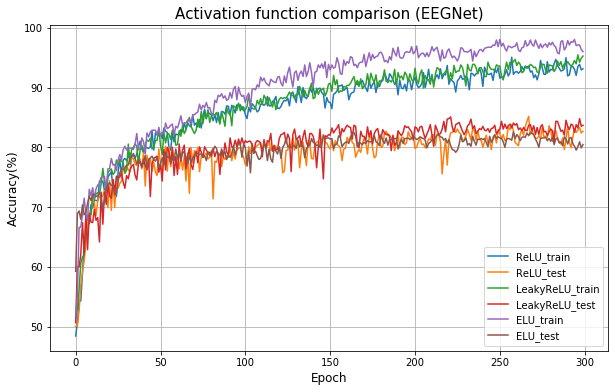

In [64]:
plt.figure(figsize=(10,6))
plt.title("Activation function comparison (EEGNet)", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Accuracy(%)", fontsize = 12)
for name in df.columns[1:]:
  plt.plot(name , data = df)
plt.grid(True)
plt.legend()
plt.show()

In [51]:
for column in df.columns[1:]:
  print('{:<15} max acc: {:.2f}'.format(column, df[column].max()))

ReLU_train      max acc: 98.24
ReLU_test       max acc: 87.50
LeakyReLU_train max acc: 97.78
LeakyReLU_test  max acc: 87.22
ELU_train       max acc: 92.41
ELU_test        max acc: 84.72


## 2. DeepConvNet

In [55]:
lr = 0.001
epochs = 300

In [59]:
df = pd.DataFrame()
df['epoch'] = range(1, epochs + 1)

criterion = nn.CrossEntropyLoss()
activation = {'ReLU':nn.ReLU(), 'LeakyReLU':nn.LeakyReLU(), 'ELU':nn.ELU()}
for name, activation in activation.items():
  print("Start training DeepConvNet with {}".format(name))
  model = DeepConvNet(activation).to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
  train_acc = []
  test_acc = []

  for epoch in range(1, epochs+1):

    ## train
    model.train()
    running_loss = 0
    correct = 0
    for i, data in enumerate(loader_train, 0):
      # get the inputs
      inputs = data[0].to(device, dtype=torch.float)
      labels = data[1].to(device, dtype=torch.long)

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      predict = model(inputs)
      loss = criterion(predict, labels)
      running_loss += loss.item()
      correct += predict.max(dim=1)[1].eq(labels).sum().item()
      loss.backward()
      optimizer.step()

    running_loss /= len(loader_train.dataset)
    train_correct = (correct / len(loader_train.dataset)) * 100.0
    train_acc.append(train_correct)

    ## test
    model.eval()
    test_correct = evaluate(model, loader_test, device)
    test_acc.append(test_correct)

    if epoch % 10 == 0:
      print("Train: epcoh{:>3d}  loss:{:.5f}  acc:{:.2f}%    Test: acc:{:.2f}%".format(epoch, running_loss, train_correct, test_correct))
  
  df[name + '_train'] = train_acc
  df[name + '_test'] = test_acc
  print("Finished training EEGNet with {}\n".format(name))

Start training DeepConvNet with ReLU
Train: epcoh 10  loss:0.00254  acc:70.37%    Test: acc:68.52%
Train: epcoh 20  loss:0.00230  acc:75.00%    Test: acc:69.91%
Train: epcoh 30  loss:0.00206  acc:78.15%    Test: acc:75.83%
Train: epcoh 40  loss:0.00195  acc:79.72%    Test: acc:76.39%
Train: epcoh 50  loss:0.00188  acc:81.94%    Test: acc:79.72%
Train: epcoh 60  loss:0.00171  acc:82.22%    Test: acc:77.69%
Train: epcoh 70  loss:0.00156  acc:85.37%    Test: acc:77.41%
Train: epcoh 80  loss:0.00145  acc:85.65%    Test: acc:78.33%
Train: epcoh 90  loss:0.00148  acc:86.94%    Test: acc:78.61%
Train: epcoh100  loss:0.00143  acc:86.76%    Test: acc:78.33%
Train: epcoh110  loss:0.00148  acc:87.22%    Test: acc:80.65%
Train: epcoh120  loss:0.00139  acc:86.57%    Test: acc:79.63%
Train: epcoh130  loss:0.00124  acc:88.33%    Test: acc:79.54%
Train: epcoh140  loss:0.00113  acc:89.26%    Test: acc:78.15%
Train: epcoh150  loss:0.00130  acc:87.59%    Test: acc:80.09%
Train: epcoh160  loss:0.00105  ac

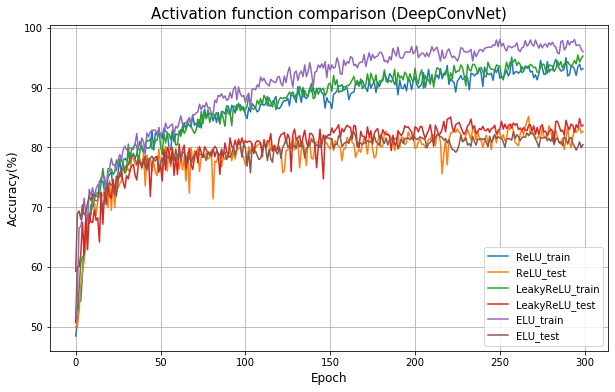

In [63]:
plt.figure(figsize=(10,6))
plt.title("Activation function comparison (DeepConvNet)", fontsize = 15)
plt.xlabel("Epoch", fontsize = 12)
plt.ylabel("Accuracy(%)", fontsize = 12)
for name in df.columns[1:]:
  plt.plot(name , data = df)
plt.grid(True)
plt.legend()
plt.show()

In [61]:
for column in df.columns[1:]:
  print('{:<15} max acc: {:.2f}'.format(column, df[column].max()))

ReLU_train      max acc: 95.09
ReLU_test       max acc: 85.19
LeakyReLU_train max acc: 95.46
LeakyReLU_test  max acc: 85.09
ELU_train       max acc: 98.06
ELU_test        max acc: 82.59
